| Step | What We’ll Do                                                                 | Notes                                |
|------|-------------------------------------------------------------------------------|--------------------------------------|
| 1    | Modify your model (build_3d_cnn) to output three outputs (class, landmarks, motion) | Multitask model                     |
| 2    | Update the data generator if needed (for landmarks ground truth)             | Automatic if you store .npy landmarks |
| 3    | Add new loss function during model compile (total_loss = classification + landmark_loss + motion_loss) | Custom training step                |
| 4    | Update your GUI prototype to capture class prediction + predicted landmarks/motion after every interval | Optional display or store results   |
| 5    | (Bonus) Write post-processing scripts to engineer features like blink rate, head turns from predicted landmarks | Extra analysis or visualization     |

| Output           | Description                                |
|------------------|--------------------------------------------|
| class_output     | Predicts suspicious / non-suspicious       |
| landmark_output  | Predicts 68 landmarks per frame            |
| motion_output    | Predicts motion magnitude between frames   |

In [49]:
import os
import numpy as np
import random
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.preprocessing import LabelEncoder

class MultitaskVideoDataGenerator(Sequence):
    def __init__(self, video_folder, landmark_folder, motion_folder, velocity_folder, class_labels, batch_size=4, shuffle=True, encoder=None, seed=32):
        
        self.video_folder = video_folder
        self.landmark_folder = landmark_folder
        self.motion_folder = motion_folder
        self.velocity_folder = velocity_folder
        self.class_labels = class_labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.encoder = encoder or LabelEncoder()
        self.rng = np.random.default_rng(seed)

        self.video_paths, self.landmark_paths, self.motion_paths, self.velocity_paths, self.labels = self._load_paths_and_labels()
        self.on_epoch_end()

    def _load_paths_and_labels(self):
        video_paths, landmark_paths, motion_paths, velocity_paths, labels = [], [], [], [], []
        for class_name in self.class_labels:
            video_class_folder = os.path.join(self.video_folder, class_name)
            landmark_class_folder = os.path.join(self.landmark_folder, class_name)
            motion_class_folder = os.path.join(self.motion_folder, class_name)
            velocity_class_folder = os.path.join(self.velocity_folder, class_name)

            for file in os.listdir(video_class_folder):
                if not file.endswith(".npy"):
                    continue
                video_paths.append(os.path.join(video_class_folder, file))
                landmark_paths.append(os.path.join(landmark_class_folder, file.replace('.npy', '_landmarks.npy')))
                motion_paths.append(os.path.join(motion_class_folder, file.replace('.npy', '_motion.npy')))
                velocity_paths.append(os.path.join(velocity_class_folder, file.replace('.npy', '_velocity.npy')))
                labels.append(class_name)

        return video_paths, landmark_paths, motion_paths, velocity_paths, labels

    def __len__(self):
        return int(np.ceil(len(self.video_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_video_paths = self.video_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_landmark_paths = self.landmark_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_motion_paths = self.motion_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_velocity_paths = self.velocity_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_frames, batch_landmarks, batch_motions, batch_velocities = [], [], [], []

        for v_path, l_path, m_path, vel_path in zip(batch_video_paths, batch_landmark_paths, batch_motion_paths, batch_velocity_paths):
            frames = np.load(v_path) / 255.0  # Normalize frames
            landmarks = np.load(l_path)
            motions = np.load(m_path)
            velocities = np.load(vel_path)

            batch_frames.append(frames)
            batch_landmarks.append(landmarks)
            batch_motions.append(motions)
            batch_velocities.append(velocities)

        if len(batch_frames) == 0:
            raise ValueError("Empty batch loaded. Check your dataset paths.")

        batch_frames = np.array(batch_frames)  # (batch_size, 20, 216, 216, 3)

        batch_landmarks = np.mean(np.array(batch_landmarks), axis=1)  # Mean over 20 frames → (batch_size, 71, 2)
        batch_landmarks = batch_landmarks.reshape(len(batch_landmarks), -1)  # (batch_size, 142)

        batch_motions = np.mean(np.array(batch_motions), axis=1)  # (batch_size, 71, 2)
        batch_motions = batch_motions.reshape(len(batch_motions), -1)  # (batch_size, 142)

        batch_velocities = np.mean(np.array(batch_velocities), axis=1)  # (batch_size, 71, 2)
        batch_velocities = batch_velocities.reshape(len(batch_velocities), -1)  # (batch_size, 142)


        batch_labels_encoded = self.encoder.transform(batch_labels)
        batch_labels_categorical = to_categorical(batch_labels_encoded, num_classes=len(self.class_labels))

        # RETURN FINAL
        return batch_frames, {
            'classification': batch_labels_categorical,
            'landmarks': batch_landmarks,
            'motion': batch_motions,
            'velocity': batch_velocities
        }

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.video_paths, self.landmark_paths, self.motion_paths, self.velocity_paths, self.labels))
            self.rng.shuffle(temp)
            self.video_paths, self.landmark_paths, self.motion_paths, self.velocity_paths, self.labels = zip(*temp)


| Part                     | Shape                          |
|--------------------------|--------------------------------|
| Input: frames            | (batch_size, 20, 216, 216, 3) |
| Output: classification   | (batch_size, 2)               |
| Output: landmarks        | (batch_size, 20, 68, 2)       |
| Output: motion           | (batch_size, 19, 68)          |
| Output: velocity         | (batch_size, 20, 68)          |

In [50]:
# Setup label encoder
CLASSES = ['Non-suspicious', 'Suspicious']
encoder = LabelEncoder()
encoder.fit(CLASSES)

SEED = 44
BATCH_SIZE = 4

train_gen = MultitaskVideoDataGenerator(
    video_folder="transformed/dataset.npy/Train",
    landmark_folder="transformed/landmarks.npy/Train",
    motion_folder="transformed/motion.npy/Train",
    velocity_folder="transformed/velocity.npy/Train",
    class_labels=CLASSES,
    batch_size=BATCH_SIZE,
    encoder=encoder,
    seed=SEED,
)

val_gen = MultitaskVideoDataGenerator(
    video_folder="transformed/dataset.npy/Val",
    landmark_folder="transformed/landmarks.npy/Val",
    motion_folder="transformed/motion.npy/Val",
    velocity_folder="transformed/velocity.npy/Val",
    class_labels=CLASSES,
    batch_size=BATCH_SIZE,
    encoder=encoder,
    seed=SEED,
)

test_gen = MultitaskVideoDataGenerator(
    video_folder="transformed/dataset.npy/Test",
    landmark_folder="transformed/landmarks.npy/Test",
    motion_folder="transformed/motion.npy/Test",
    velocity_folder="transformed/velocity.npy/Test",
    class_labels=CLASSES,
    batch_size=BATCH_SIZE,
    encoder=encoder,
    seed=SEED,
    shuffle=False
)


In [51]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, GlobalAveragePooling3D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Constants
IMG_SIZE = 216
FRAMES = 20
CHANNELS = 3
NUM_CLASSES = 2
NUM_LANDMARKS = 71
NUM_COORDINATES = 2  # (x, y)
TIME_GAP = 0.75  # seconds per frame gap
MODEL_VERSION = "v1.17"

def build_multitask_3dcnn(input_shape=(FRAMES, IMG_SIZE, IMG_SIZE, CHANNELS)):
    inputs = Input(shape=input_shape)

    # 3D CNN Backbone with regularization
    x = Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling3D((1, 2, 2))(x)

    x = Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D((2, 2, 2))(x)

    x = Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D((2, 2, 2))(x)

    x = Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D((2, 2, 2))(x)

    x = GlobalAveragePooling3D()(x)

    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)

    # Multitask Heads

    # Classification Head
    classification_output = Dense(NUM_CLASSES, activation='softmax', name='classification')(x)

    # Landmark Regression Head
    landmarks_output = Dense(NUM_LANDMARKS * NUM_COORDINATES, activation='sigmoid', name='landmarks')(x)

    # Motion Prediction Head
    motion_output = Dense(NUM_LANDMARKS * NUM_COORDINATES, activation='linear', name='motion')(x)

    # Velocity Prediction Head
    velocity_output = Dense(NUM_LANDMARKS * NUM_COORDINATES, activation='linear', name='velocity')(x)

    # Final Model
    model = Model(inputs=inputs, outputs=[
        classification_output,
        landmarks_output,
        motion_output,
        velocity_output
    ])
    
    # Scheduled (gradual) learning rate decay
    initial_learning_rate = 0.0005
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=30 * len(train_gen),  # Every ~30 epochs worth of batches
        decay_rate=0.8,                  # Decay by 20% every 30 epochs
        staircase=True
    )

    # Use Adam with scheduled decay
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile
    model.compile(
        optimizer=optimizer,
        loss={
            'classification': 'categorical_crossentropy',
            'landmarks': 'mse',
            'motion': 'mse',
            'velocity': 'mse'
        },
        loss_weights={
            'classification': 1.0,   # Main Task
            'landmarks': 0.2,        # Auxiliary (facial structure)
            'motion': 0.2,           # Auxiliary (movement dynamics)
            'velocity': 0.2           # Auxiliary (speed of movement)
        },
        metrics={
            'classification': 'accuracy',
            'landmarks': 'mse',
            'motion': 'mse',
            'velocity': 'mse'
        }
    )

    return model

model = build_multitask_3dcnn()
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 20, 216,   │          0 │ -                 │
│ (InputLayer)        │ 216, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_28 (Conv3D)  │ (None, 20, 216,   │      2,624 │ input_layer_7[0]… │
│                     │ 216, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 216,   │        128 │ conv3d_28[0][0]   │
│ (BatchNormalizatio… │ 216, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_28    │ (None, 20, 108,   │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 108, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_29 (Conv3D)  │ (None, 20, 108,   │     55,360 │ max_pooling3d_28… │
│                     │ 108, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 108,   │        256 │ conv3d_29[0][0]   │
│ (BatchNormalizatio… │ 108, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_29    │ (None, 10, 54,    │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 54, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_30 (Conv3D)  │ (None, 10, 54,    │    221,312 │ max_pooling3d_29… │
│                     │ 54, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 54,    │        512 │ conv3d_30[0][0]   │
│ (BatchNormalizatio… │ 54, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_30    │ (None, 5, 27, 27, │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_31 (Conv3D)  │ (None, 5, 27, 27, │    884,992 │ max_pooling3d_30… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 27, 27, │      1,024 │ conv3d_31[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_31    │ (None, 2, 13, 13, │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ max_pooling3d_31… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 512)       │    131,584 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 512)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 2)         │      1,026 │ dropout_7[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,517,356 (5.79 MB)

 Trainable params: 1,516,396 (5.78 MB)

 Non-trainable params: 960 (3.75 KB)

In [52]:
X, Y = train_gen[0]

print(X.shape)
print(Y['classification'].shape)
print(Y['landmarks'].shape)
print(Y['motion'].shape)
print(Y['velocity'].shape)


(4, 20, 216, 216, 3)
(4, 2)
(4, 142)
(4, 142)
(4, 142)


In [53]:
import os
import matplotlib.pyplot as plt

folder_name = f"plotloss/examination_behavior-{FRAMES}F-{IMG_SIZE}IS-{MODEL_VERSION}"

def plot_and_save_training_history(history, folder_name):
    # Create folder if not exists
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(f"Created folder: {folder_name}")

    # Extract losses
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    classification_loss = history.history['classification_loss']
    val_classification_loss = history.history['val_classification_loss']

    landmarks_loss = history.history['landmarks_loss']
    val_landmarks_loss = history.history['val_landmarks_loss']

    motion_loss = history.history['motion_loss']
    val_motion_loss = history.history['val_motion_loss']

    velocity_loss = history.history['velocity_loss']
    val_velocity_loss = history.history['val_velocity_loss']

    epochs = range(1, len(loss) + 1)

    # Helper function to plot, save, and show properly
    def plot_save_show(epochs, train_loss, val_loss, title, filename):
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_loss, label='Train')
        plt.plot(epochs, val_loss, label='Validation')
        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()

        # Save first
        save_path = os.path.join(folder_name, filename)
        plt.savefig(save_path)

        # THEN show nicely
        plt.show()

        print(f"Saved and displayed: {save_path}")

    # Plot each loss nicely
    plot_save_show(epochs, loss, val_loss, 'Total Loss Over Epochs', 'total_loss.png')
    plot_save_show(epochs, classification_loss, val_classification_loss, 'Classification Loss', 'classification_loss.png')
    plot_save_show(epochs, landmarks_loss, val_landmarks_loss, 'Landmark Loss', 'landmarks_loss.png')
    plot_save_show(epochs, motion_loss, val_motion_loss, 'Motion Loss', 'motion_loss.png')
    plot_save_show(epochs, velocity_loss, val_velocity_loss, 'Velocity Loss', 'velocity_loss.png')

/mnt/c/Users/Raymond/Desktop/3D-CNN/env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - classification_accuracy: 0.5162 - classification_loss: 0.8998 - landmarks_loss: 0.0337 - landmarks_mse: 0.0337 - loss: 1.1300 - motion_loss: 0.3965 - motion_mse: 0.3965 - velocity_loss: 0.3989 - velocity_mse: 0.3989

/mnt/c/Users/Raymond/Desktop/3D-CNN/env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.79379, saving model to models/best_model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 66s 959ms/step - classification_accuracy: 0.5154 - classification_loss: 0.8993 - landmarks_loss: 0.0335 - landmarks_mse: 0.0335 - loss: 1.1284 - motion_loss: 0.3941 - motion_mse: 0.3941 - velocity_loss: 0.3965 - velocity_mse: 0.3965 - val_classification_accuracy: 0.5000 - val_classification_loss: 0.6945 - val_landmarks_loss: 0.0131 - val_landmarks_mse: 0.0132 - val_loss: 0.7938 - val_motion_loss: 0.0769 - val_motion_mse: 0.0769 - val_velocity_loss: 0.0719 - val_velocity_mse: 0.0719
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - classification_accuracy: 0.4968 - classification_loss: 0.7820 - landmarks_loss: 0.0156 - landmarks_mse: 0.0156 - loss: 0.8936 - motion_loss: 0.1101 - motion_mse: 0.1101 - velocity_loss: 0.1111 - velocity_mse: 0.1111
Epoch 2: val_loss did not improve from 0.79379
58/58 ━━━━━━━━━━━━━━━━━━━━ 52s 901ms/step - classification_accuracy: 0.4964 - c

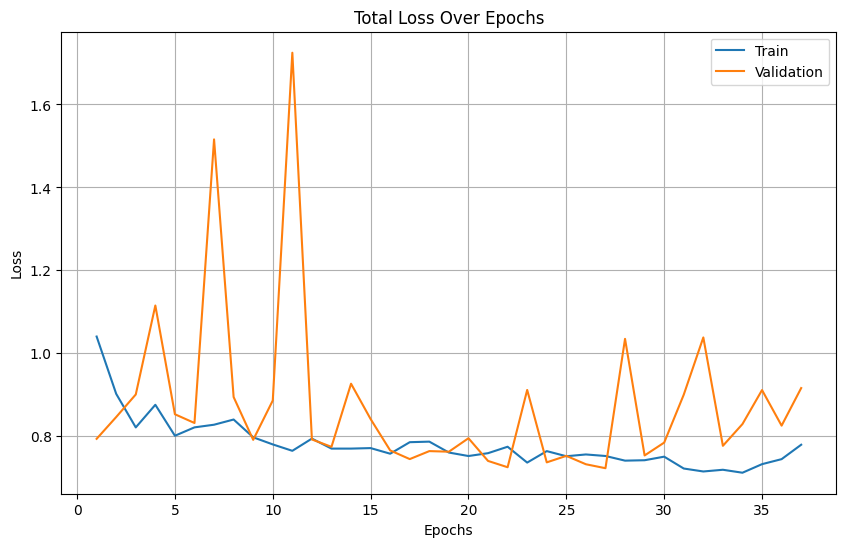

Saved and displayed: plotloss/examination_behavior-20F-216IS-v1.17/total_loss.png


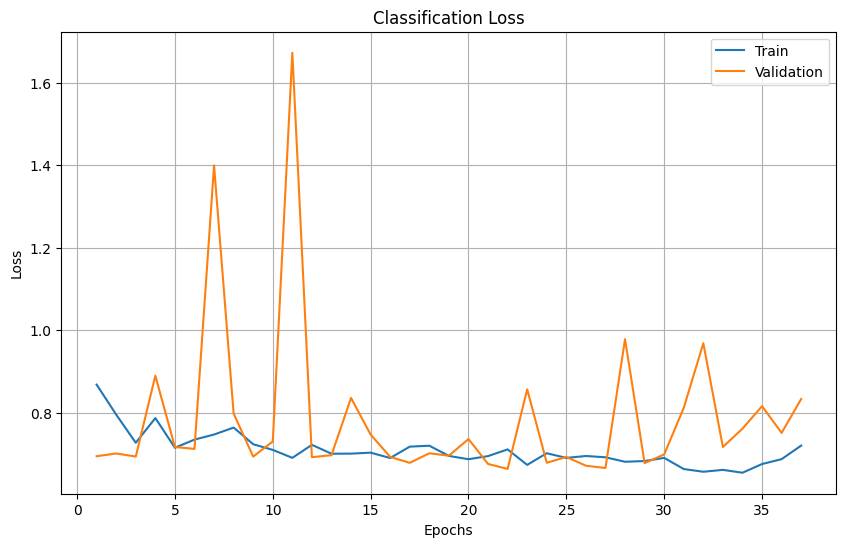

Saved and displayed: plotloss/examination_behavior-20F-216IS-v1.17/classification_loss.png


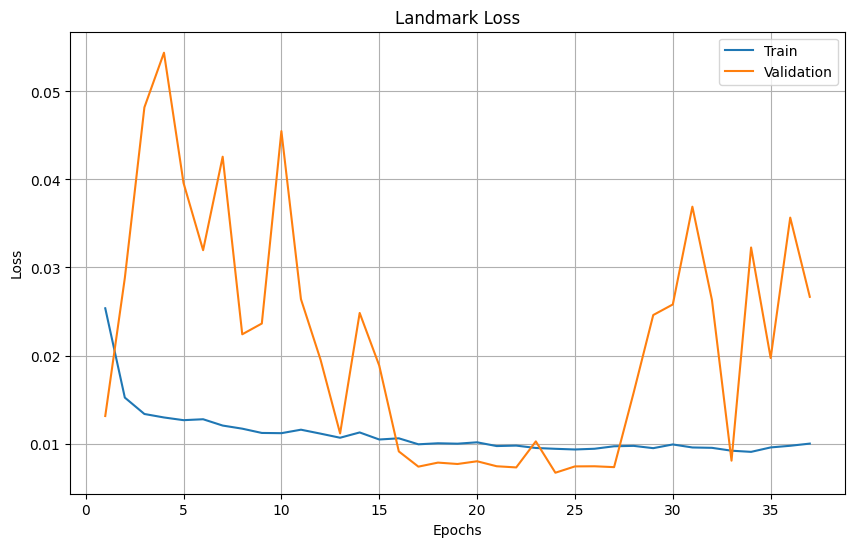

Saved and displayed: plotloss/examination_behavior-20F-216IS-v1.17/landmarks_loss.png


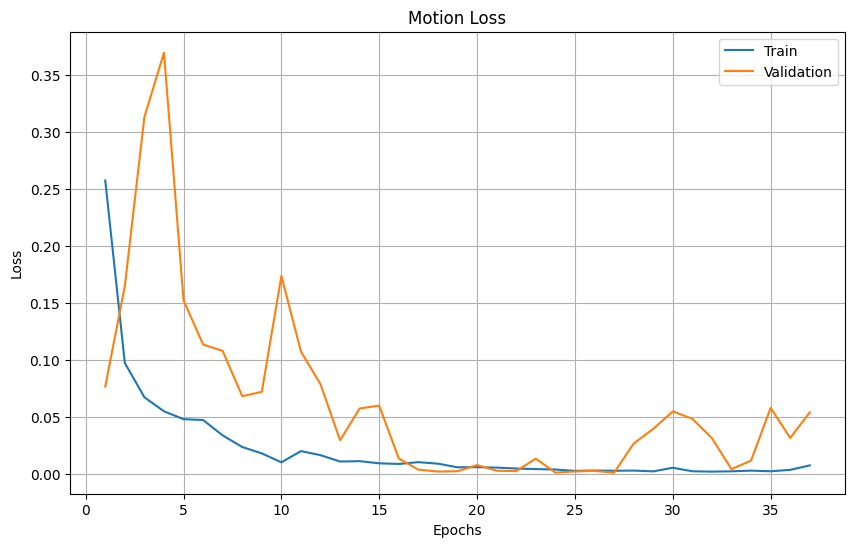

Saved and displayed: plotloss/examination_behavior-20F-216IS-v1.17/motion_loss.png


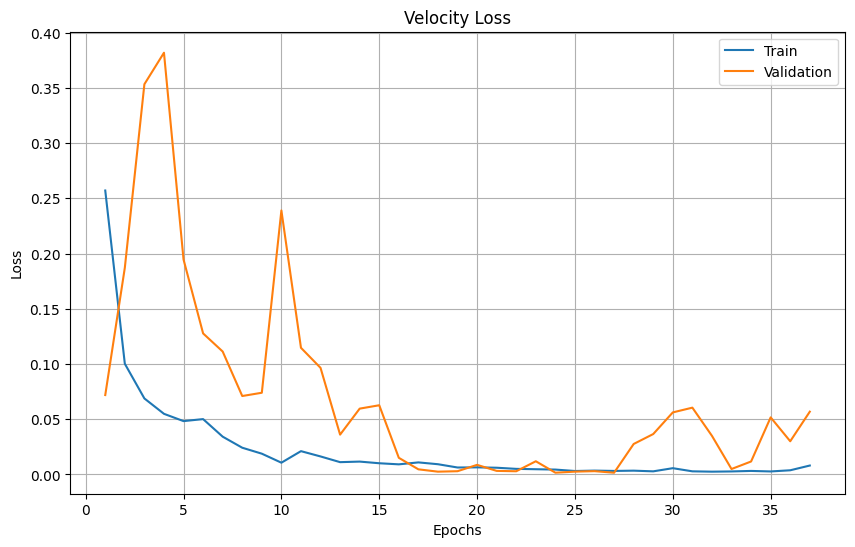

Saved and displayed: plotloss/examination_behavior-20F-216IS-v1.17/velocity_loss.png


In [54]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

model_name = f"examination_behavior-{FRAMES}F-{IMG_SIZE}IS-{MODEL_VERSION}.keras"
save_folder = "models"

checkpoint = ModelCheckpoint(
    filepath=os.path.join(save_folder, "best_model.keras"),  # Save inside your model_name folder
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[early_stop, checkpoint],   
    shuffle=False
)

os.makedirs(save_folder, exist_ok=True)

# Save the trained model
model.save(os.path.join(save_folder, model_name))

# Plot and save training history
plot_and_save_training_history(history, folder_name)

# Append model summary to a markdown file
with open("model_summary.md", "a") as f:
    f.write(f"## Model Name: {model_name}\n")
    model.summary(print_fn=lambda x: f.write(x + '\n'))

/mnt/c/Users/Raymond/Desktop/3D-CNN/env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 495ms/step - classification_accuracy: 0.3939 - classification_loss: 0.7826 - landmarks_loss: 0.0079 - landmarks_mse: 0.0079 - loss: 0.8417 - motion_loss: 0.0013 - motion_mse: 0.0013 - velocity_loss: 0.0014 - velocity_mse: 0.0014   

--- Evaluation Results
classification_accuracy: 0.6111
classification_loss: 0.6861
landmarks_loss: 0.0084
landmarks_mse: 0.0084
loss: 0.7454
motion_loss: 0.0014
motion_mse: 0.0014
velocity_loss: 0.0016
velocity_mse: 0.0016
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step

--- Classification Report
                precision    recall  f1-score   support

    Suspicious       0.75      0.33      0.46        18
Non-suspicious       0.57      0.89      0.70        18

      accuracy                           0.61        36
     macro avg       0.66      0.61      0.58        36
  weighted avg       0.66      0.61      0.58        36


Cohen's Kappa Score: 0.2222


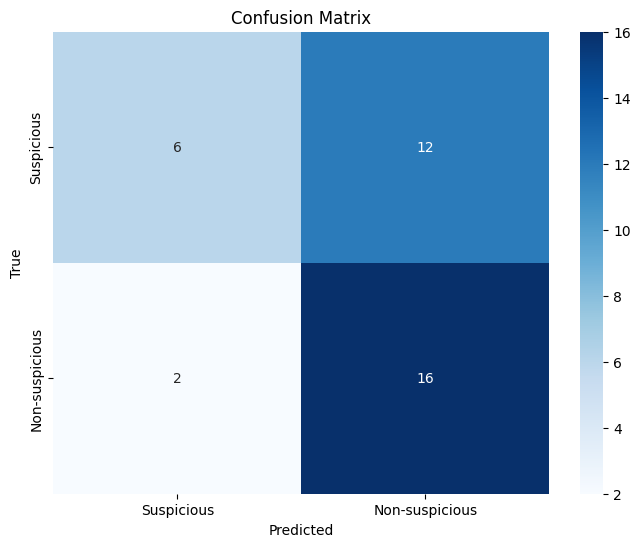

In [55]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

model_name = f"models/examination_behavior-{FRAMES}F-{IMG_SIZE}IS-{MODEL_VERSION}.keras"


# Load your trained model
# model = tf.keras.models.load_model("examination_behavior-20F-216IS-v1.0.keras")
model = tf.keras.models.load_model(model_name)

# Evaluate model on test set
# This will return a list of all loss and metrics
metrics = model.evaluate(test_gen, verbose=1, return_dict=True)

# Print metrics
print("\n--- Evaluation Results")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

# Now predict on test set
# Multitask model returns 4 outputs
predictions = model.predict(test_gen, verbose=1)

# Separate predictions
class_pred = predictions[0]        # (batch_size, 2)
landmarks_pred = predictions[1]    # (batch_size, 142)
motion_pred = predictions[2]       # (batch_size, 142)
velocity_pred = predictions[3]     # (batch_size, 142)

# Get true labels
def get_all_true_labels(generator):
    all_labels = []
    for i in range(len(generator)):
        _, labels = generator[i]
        all_labels.extend(np.argmax(labels['classification'], axis=1))
    return np.array(all_labels)

y_true = get_all_true_labels(test_gen)
y_pred = np.argmax(class_pred, axis=1)

# Classification report
CLASSES = ['Suspicious', 'Non-suspicious']

report_str = classification_report(y_true, y_pred, target_names=CLASSES)
print("\n--- Classification Report")
print(report_str)

# Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"\nCohen's Kappa Score: {kappa:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Save evaluation to Markdown file
with open("model_summary.md", "a") as f:
    f.write("## Model Evaluation Results (Multitask)\n\n")
    
    f.write("### Metrics Summary\n")
    for key, value in metrics.items():
        f.write(f"- **{key}**: {value:.4f}\n")
    
    f.write("\n### Classification Report\n```\n")
    f.write(report_str)
    f.write("\n```\n\n")
    
    f.write("### Confusion Matrix\n")
    f.write(conf_matrix_df.to_markdown(index=False))
    f.write("\n\n")
    
    f.write(f"### Cohen's Kappa Score: {kappa:.4f}\n\n\n\n")